In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm 
from matplotlib import ticker
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
from scipy import optimize
from scipy.linalg import lu_factor, lu_solve
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy.special import roots_legendre
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline
import ipywidgets as widgets
eps = np.finfo(float).eps

In [2]:
import empymod
import discretize
from simpeg.simulation import BaseSimulation, BaseTimeSimulation
from simpeg import props
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg import props
from simpeg.survey import BaseSrc, BaseRx, BaseSurvey
from simpeg.maps import IdentityMap

In [3]:
#from empymodDeepSea import empymodDeepSea
from PsuedoLog import PsuedoLog  

In [4]:
#class empymodDeepSea(BaseSimulation):
class empymodDeepSea(BaseTimeSimulation):    
    """
    Class for one dimensional inversion for about Induced Polarization from
    Time-Domain Electromagnetic about Sea Massive Sulfide Exploration.
    Forward modelling: empymod
    https://empymod.emsig.xyz/en/stable/index.html

    Forward simulation

    model        :all parameter which is used for simulation
                   including resistivity of air, sea water.
                   bottom fix is also available

    model vector : parameter used for inversion
                   assuming IP parameter for seafloor hydrothermal deposit
                   
    IP_model: String
        "cole":
            res0: resistivity in low frequency
            res8: resistivity in hig frequency
            tau : time constant
            c   : exponent c

        "pelton":
            res : resistivity
            chg : chargeability
            tau : time constant
            c   : exponent c

    res_sea: resistivity of sea to fix during inversion

    nlayers: integer, number of layers

    btm_fix: indicate if you want to fix parameter for bottom layer
        None: no fix (default)
        True: fix, recommended when creating object function grid

    res_btm: resistivity of bottom layer to fix during inversion
             eligible when btm_fix is 1

    model_base: please refer empymod tutorial
    https://empymod.emsig.xyz/en/stable/api/empymod.model.dipole.html
        'src':  transmitter configuration
        'rec': receiver configuration
        'depth': depth,
        'freqtime': t as time domain
        'signal': signal wave
        'verb': 0
     """
    
    model_vector  = props.Invertible(
        "The model for a empymod deepsea problem."
    )

    def __init__(self, IP_model, model_base, res_sea, nlayers, 
                model_vector=None,  
                btm_fix=None, res_btm=None,
                data_filter=None, freq_smp=None, time_clc=None,
                ramp_time=None,
                window_cen=None, window_strt = None, window_end = None,
                resmin=1e-3 , resmax=1e6, chgmin=1e-5, chgmax=0.99,
                taumin=1e-6, taumax=1e-2, cmin= 0.4, cmax=0.8,
                Wd = None, Ws=None, Wx=None, Hessian=None, Jacobian=None
                ,**kwargs):
        super().__init__(**kwargs)
        self.model_vector = model_vector
        self.IP_model = IP_model
        self.model_base = model_base
        self.res_sea = res_sea
        self.nlayers = nlayers
        self.btm_fix = btm_fix
        self.res_btm = res_btm
        self.data_filter = data_filter
        self.freq_smp = freq_smp
        self.time_clc = time_clc
        self.ramp_time = ramp_time
        self.window_cen = window_cen
        self.window_strt = window_strt
        self.window_end = window_end
        self.resmin = resmin
        self.resmax = resmax
        self.chgmin = chgmin
        self.chgmax = chgmax
        self.taumin = taumin
        self.taumax = taumax
        self.cmin = cmin
        self.cmax = cmax
        self.Wd = Wd
        self.Ws = Ws
        self.Wx = Wx
        self.Hessian = Hessian
        self.Jacobian = Jacobian

    def cole_cole(self, inp, p_dict):
        """Cole and Cole (1941)."""

        # Compute complex conductivity from Cole-Cole
        iotc = np.outer(2j * np.pi * p_dict['freq'], inp['tau']) ** inp['c']
        condH = inp['cond_8'] + (inp['cond_0'] - inp['cond_8']) / (1 + iotc)
        condV = condH / p_dict['aniso'] ** 2

        # Add electric permittivity contribution
        etaH = condH + 1j * p_dict['etaH'].imag
        etaV = condV + 1j * p_dict['etaV'].imag
        PA_plot = 0
        if PA_plot == 1:
            freq = p_dict['freq']
            amplitude = np.abs(1 / condH)[:, 1]
            phase = np.angle(1 / condH)[:, 1]
            #    m_colecole = (inp['cond_8'][2]-inp['cond_0'][2])/inp['cond_8'][2]

            csv_colecole = np.array([freq, amplitude, phase]).T
            with open('EOSC555_Rep_PA_ColeCole.csv', 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(['freq', 'amplitude', 'phase'])  # Write header row
                writer.writerows(csv_colecole)

        return etaH, etaV

    def pelton_et_al(self, inp, p_dict):
        """ Pelton et al. (1978)."""

        # Compute complex resistivity from Pelton et al.
        iotc = np.outer(2j * np.pi * p_dict['freq'], inp['tau']) ** inp['c']
        rhoH = inp['rho_0'] * (1 - inp['m'] * (1 - 1 / (1 + iotc)))
        rhoV = rhoH * p_dict['aniso'] ** 2

        # Add electric permittivity contribution
        etaH = 1 / rhoH + 1j * p_dict['etaH'].imag
        etaV = 1 / rhoV + 1j * p_dict['etaV'].imag

        PA_plot = 0
        if PA_plot == 1:
            frq_pl = p_dict['freq']
            amp_pl = np.abs(rhoH)[:, 2]
            phs_pl = np.angle(rhoH)[:, 2]
            fig, ax1 = plt.subplots(figsize=(8, 5))

            # Plotting magnitude on the left y-axis (log scale)
            ax1.set_xscale('log')
            ax1.set_ylabel('Amplitude')
            ax1.set_xlabel('Frequency')
            ax1.semilogx(frq_pl, amp_pl, 'r',label='Amplitude')  # Blue line for magnitude
            ax1.set_ylim(bottom=0)  # Set the lower limit of the y-axis to 0

            # Enable grid only for x-axis
            ax1.xaxis.grid(True)
            ax1.yaxis.grid(False)  # Disable grid for y-axis

            # Creating a second y-axis for phase on the right
            ax2 = ax1.twinx()
            ax2.set_ylabel('Phase (radians)')
            ax2.semilogx(frq_pl, phs_pl,  'b-',label='phase')  # Red line for phase
            ax2.invert_yaxis()

            # Combine legends from both axes
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            lines = lines1 + lines2
            labels = labels1 + labels2
            ax1.legend(lines, labels, loc='best')

            plt.title('Phase Amplitude Plot-Pelton model')
            plt.savefig('Pelton.png', dpi=300)
            plt.show()
            # csv_colecole = np.array([freq, amplitude, phase]).T
            # with open('EOSC555_Rep_PA_Pelton.csv', 'w', newline='') as csvfile:
            #     writer = csv.writer(csvfile)
            #     writer.writerow(['freq', 'amplitude', 'phase'])  # Write header row
            #     writer.writerows(csv_colecole)

        return etaH, etaV

    def get_ip_model(self, model_vector=None):
        if model_vector is None:
            model_vector = self.model_vector

        if self.IP_model == "cole":
            if self.btm_fix == True:
                res_0 = np.hstack([[self.res_sea],
                                   np.exp(model_vector[:self.nlayers]), [self.res_btm]])
                res_8 = np.hstack([[self.res_sea],
                                   np.exp(model_vector[self.nlayers:2 * self.nlayers]), [self.res_btm]])
                tau = np.hstack([[self.taumin],
                                 np.exp(model_vector[2 * self.nlayers:3 * self.nlayers]), self.taumin])
                c = np.hstack([[self.cmin], model_vector[3 * self.nlayers:4 * self.nlayers], [self.cmin]])
                cole_model = {'res': res_0, 'cond_0': 1 / res_0, 'cond_8': 1 / res_8,
                              'tau': tau, 'c': c, 'func_eta': self.cole_cole}
                return cole_model
            else:
                res_0 = np.hstack([[self.res_sea],
                                   np.exp(model_vector[:self.nlayers])])
                res_8 = np.hstack([[self.res_sea],
                                   np.exp(model_vector[self.nlayers:2 * self.nlayers])])
                tau = np.hstack([[self.taumin],
                                 np.exp(model_vector[2 * self.nlayers:3 * self.nlayers])])
                c = np.hstack([[self.cmin], model_vector[3 * self.nlayers:4 * self.nlayers]])
                cole_model = {'res': res_0, 'cond_0': 1 / res_0, 'cond_8': 1 / res_8,
                              'tau': tau, 'c': c, 'func_eta': self.cole_cole}
                return cole_model

        if self.IP_model == "pelton":
            if self.btm_fix == True:
                res = np.hstack([[self.res_sea],
                                 np.exp(model_vector[:self.nlayers]), [self.res_btm]])
                m = np.hstack([[0.], model_vector[self.nlayers:2 * self.nlayers], [0.]])
                tau = np.hstack([[self.taumin], np.exp(model_vector[2 * self.nlayers:3 * self.nlayers]), self.taumin])
                c = np.hstack([[self.cmin], model_vector[3 * self.nlayers:4 * self.nlayers], [self.cmin]])
                pelton_model = {'res': res, 'rho_0': res, 'm': m,
                                'tau': tau, 'c': c, 'func_eta': self.pelton_et_al}
                return pelton_model
            else:
                res = np.hstack([[self.res_sea], np.exp(model_vector[:self.nlayers])])
                m = np.hstack([[0], model_vector[self.nlayers:2 * self.nlayers]])
                tau = np.hstack([[self.taumin],np.exp(model_vector[2 * self.nlayers:3 * self.nlayers])])
                c = np.hstack([[self.cmin], model_vector[3 * self.nlayers:4 * self.nlayers]])
                pelton_model = {'res': res, 'rho_0': res, 'm': m,
                                'tau': tau, 'c': c, 'func_eta': self.pelton_et_al}
                return pelton_model

    def plot_model(self, model, ax=None, color='C0', label="model", linewidth=1,depth_min=-100):
        if ax is None:
            fig, ax = plt.subplot(1,1,figsize=(4,8))
        depth = np.r_[depth_min,self.model_base["depth"]]
        depth_plot = np.vstack([depth, depth]).flatten(order="F")[1:]
        depth_plot = np.hstack([depth_plot, depth_plot[-1] * 1.5])
        model_plot = np.vstack([model, model]).flatten(order="F")
        return ax.plot(model_plot, depth_plot, color, label=label,  linewidth=linewidth)

    def plot_IP_par(self,model_vector=None,color="orange",  label="",  linewidth=1.0,ax=None):
        """"
        Return four plots about four IP parameters on given ax.
        mvec: model vector
        label, color: will be reflected on 
        color: 
        ax: Assuming four element in axis 0.
        """""
        if ax is None:
            fig, ax = plt.subplots(2, 2, figsize=(12, 8))

        if model_vector is None:
            model_vector = self.model_vector

        # convert model vector to model
        model = self.get_ip_model(model_vector)

        # plot_model_m(model_base["depth"], model_ip["res"], ax[0], "resistivity","k")
        self.plot_model(model["res"], ax[0], color, label=label, linewidth=linewidth)
        if self.IP_model == "cole":
            self.plot_model(1 - model["cond_0"] / model["cond_8"], ax[1], color, label=label, linewidth=linewidth)
        else:
            self.plot_model(model["m"], ax[1],  color, label=label, linewidth=linewidth)

        self.plot_model(model["tau"], ax[2],  color, label=label, linewidth=linewidth)

        self.plot_model(model["c"]  , ax[3],  color, label=label, linewidth=linewidth)

        ax[0].set_title("model_resistivity(ohm-m)")
        ax[1].set_title("model_changeability")
        ax[2].set_title("model_time_constant(sec)")
        ax[3].set_title("model_exponent_c")

        return ax

    def fields(self, model_vector):
#        self.model_vector = m
        self.model_vector = model_vector
        return self.dpred(self.model_vector)

    def dpred(self, model_vector,f=None):
        self.model_vector = model_vector

        ip_model = self.get_ip_model(self.model_vector)
        data_sim = empymod.bipole(res=ip_model, **self.model_base)

        if data_sim.ndim == 3:
            # Sum over transmitter and receiver dimensions (axis 1 and axis 2)
            data_sim=np.sum(data_sim, axis=(1, 2))
        elif data_sim.ndim == 2:
            # Sum over the transmitter dimension (axis 1)
            data_sim= np.sum(data_sim, axis=1)

        if self.freq_smp is None:
            return data_sim

        # Get the time vector
        time_clc = self.model_base["freqtime"]
        nstep_clc = len(time_clc)
        # Check if time_clc is equally spaced
        time_clc_diff = np.diff(time_clc)
        if not np.allclose(time_clc_diff, time_clc_diff[0]):
            raise ValueError("time_clc is not equally spaced.")

        # Calculate time interval
        time_clc_int = time_clc_diff[0]
        data_LPF = self.LPF_AD(np.r_[0,data_sim],time_clc_int)[1:]
        
        if self.data_filter is None:
            return data_LPF
        
        data_filt =  signal.convolve(data_LPF, self.data_filter,mode='full')[:nstep_clc]
        
        if self.window_cen is None:
            return data_filt
        
        data_window = self.window(time_clc, data_filt)

        return data_window
       

    def LPF_AD(self, data,time_clc_int,order=1):
        fs = 1/time_clc_int
        nyquist = 0.5 * fs
        normal_cutoff = self.freq_smp / nyquist
        #print(fs, nyquist, normal_cutoff)
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        data = filtfilt(b, a, data)
        return data

    def get_window(self,tstrt, tend,logstep):
        logstrt = np.log10(tstrt)
        logend = np.log10(tend)
        self.window_cen  = 10.**(np.arange(logstrt,logend,logstep))
        self.window_strt = 10.**(np.arange(logstrt-logstep/2,logend-logstep/2,logstep))
        self.window_end  = 10.**(np.arange(logstrt+logstep/2,logend+logstep/2,logstep))
        print(f'log step: {len(self.window_cen)}')

    def window(self,times,data):
        wid_size = len(self.window_strt)
        ramp_time = self.ramp_time
        window_strt = self.window_strt +ramp_time
        window_end = self.window_end + ramp_time
        window_data = np.zeros(wid_size)
        for i in range(wid_size):
            index_window =  (times>= window_strt[i]) & (times <= window_end[i])
            if index_window.sum() > 0:
                window_data[i] = np.average(data[index_window])
        return window_data

    def constrain_model_vector(self, model_vector):
        "Parametert Projection based on provided bound"

        model_vector[:self.nlayers] = np.clip(
            model_vector[:self.nlayers], np.log(self.resmin), np.log(self.resmax))
        if self.IP_model == "cole":
            for i in range(self.nlayers):
                resmaxi = model_vector[i]
                model_vector[self.nlayers + i] = np.clip(
                model_vector[self.nlayers + i], np.log(self.resmin), resmaxi)
        else:
            model_vector[self.nlayers:2 * self.nlayers] = np.clip(
                model_vector[self.nlayers:2 * self.nlayers], self.chgmin, self.chgmax)
            # model_vector[self.nlayers:2 * self.nlayers] = np.clip(
            #     model_vector[self.nlayers:2 * self.nlayers], np.log(self.chgmin), np.log(self.chgmax))
        model_vector[2 * self.nlayers:3 * self.nlayers] = np.clip(
            model_vector[2 * self.nlayers:3 * self.nlayers], np.log(self.taumin), np.log(self.taumax))
        model_vector[3 * self.nlayers:4 * self.nlayers] = np.clip(
            model_vector[3 * self.nlayers:4 * self.nlayers], self.cmin, self.cmax)
        return model_vector


    def projection_halfspace(self,a,x,b):
        "project vector to half space {x | <a,x> <=b "
        if np.all(np.dot(a,x) <= b):
            return x
        else:
            return x + a*( (b-np.dot(a,x))/np.dot(a,a) )

    def proj_c(self,mvec_tmp,maxitr = 100, tol = 1e-6):
        "Project model vector to convex set defined by bound information"
        mvec = mvec_tmp.copy()
        nlayers = self.nlayers
        a_r0  = np.r_[ 1., 0.]
        # a_r8  = np.r_[ 0., 1.]
        a_r08 = np.r_[-1., 1.]
        a = np.r_[1]

        if self.IP_model == "cole" :
            for j in range(nlayers):
                r0_tmp = mvec[j]
                r8_tmp = mvec[j + nlayers]
                r08_tmp = np.r_[r0_tmp, r8_tmp]
                r08_prj = r08_tmp
                for i in range(maxitr):
                    r08_prj = self.projection_halfspace(  a_r0, r08_prj,  np.log(self.resmax))
                    r08_prj = self.projection_halfspace( -a_r0, r08_prj, -np.log(self.resmin))
                    # r08_prj = self.projection_halfspace( a_r8, r08_prj,   np.log(self.resmax))
                    # r08_prj = self.projection_halfspace(-a_r8, r08_prj, -np.log(self.resmin))
                    r08_prj = self.projection_halfspace(-a_r08, r08_prj, -np.log(1-self.chgmax))
                    r08_prj = self.projection_halfspace( a_r08, r08_prj,  np.log(1-self.chgmin))
                    if np.linalg.norm(r08_prj - r08_tmp) <= tol:
                        break
                    r08_tmp = r08_prj
                mvec[j          ] = r08_prj[0]
                mvec[j + nlayers] = r08_prj[1]

        else:
            for j in range(nlayers):
                r_prj = mvec[j]
                m_prj = mvec[j+nlayers]
                r_prj = self.projection_halfspace( a, r_prj, np.log(self.resmax))
                r_prj = self.projection_halfspace(-a, r_prj,-np.log(self.resmin))
                m_prj = self.projection_halfspace( a, m_prj, self.chgmax)
                m_prj = self.projection_halfspace(-a, m_prj,-self.chgmin)
                mvec[j        ] = r_prj
                mvec[j+nlayers] = m_prj

        for j in range(nlayers):
            t_prj = mvec[j + 2*nlayers]
            c_prj = mvec[j + 3*nlayers]
            t_prj = self.projection_halfspace( a, t_prj,  np.log(self.taumax))
            t_prj = self.projection_halfspace(-a, t_prj, -np.log(self.taumin))
            c_prj = self.projection_halfspace( a, c_prj,  self.cmax)
            c_prj = self.projection_halfspace(-a, c_prj, -self.cmin)
            mvec[j + 2*nlayers] = t_prj
            mvec[j + 3*nlayers] = c_prj
        return mvec


    def Japprox(self, model_vector, perturbation=0.1, min_perturbation=1e-3):
        """
        Approximate sensitivity computed using a finite difference approach
        """
        delta_m = min_perturbation  # np.max([perturbation*m.mean(), min_perturbation])
#        delta_m = perturbation  # np.max([perturbation*m.mean(), min_perturbation])
        J = []

        for i, entry in enumerate(model_vector):
            mpos = model_vector.copy()
            mpos[i] = entry + delta_m

            mneg = model_vector.copy()
            mneg[i] = entry - delta_m

            mpos = self.constrain_model_vector(mpos)
            mneg = self.constrain_model_vector(mneg)


            pos = self.dpred(self.constrain_model_vector(mpos))
            neg = self.dpred(self.constrain_model_vector(mneg))
            J.append((pos - neg) / (2. * delta_m))

        return np.vstack(J).T

    def Jvec(self, model_vector,v,f=None):
        """
        Sensitivity times a vector
        """
        return self.Japprox(model_vector).dot(v)

    def Jtvec(self, model_vector,v,f=None):
        """
        Adjoint Sensitivity times a vector
        """
        return self.Japprox(model_vector).T.dot(v)

    def get_Wd(self, dobs, dp=1, ratio=0.01, plateau=1e-5):
        """
        Calculate and return a diagonal matrix Wd based on a standard deviation std.

        The standard deviation std is calculated as follows: (abs(dobs * ratio) ^ dp) + plateau.
        The diagonal matrix Wd is then calculated as the inverse of the standard deviation std.

        Parameters
        ----------
        dobs : ndarray
            The observed data.
        dp : int, optional
            The power to which the absolute value of dobs * ratio is raised (default is 1).
        ratio : float, optional
            A constant used in the calculation of the standard deviation (default is 0.01).
        plateau : float, optional
            A small constant added to avoid division by zero (default is 1e-5).

        Returns
        -------
        ndarray
            A diagonal matrix with the elements of 1 / std on the main diagonal.
        """
        std = np.abs(dobs * ratio) ** dp + plateau
        return np.diag(1 / std)

    def set_Wd(self, dobs, dp=1, ratio=0.01, plateau=1e-5 ):
        """
        Calculate a diagonal matrix Wd based on a standard deviation std and set it as an attribute of the class instance.

        The standard deviation std is calculated as follows: (abs(dobs * ratio) ^ dp) + plateau.
        The diagonal matrix Wd is then calculated as the inverse of the standard deviation std.

        Parameters
        ----------
        dobs : ndarray
            The observed data.
        dp : int, optional
            The power to which the absolute value of dobs * ratio is raised (default is 1).
        ratio : float, optional
            A constant used in the calculation of the standard deviation (default is 0.01).
        plateau : float, optional
            A small constant added to avoid division by zero (default is 1e-5).

        Returns
        -------
        None
        """
        std = np.abs(dobs * ratio) ** dp + plateau
        self.Wd = np.diag(1 / std)
        return

    def get_Ws(self):
        nx = 4*self.nlayers
        return np.diag(np.ones(nx))

    def set_Ws(self):
        nx = 4*self.nlayers
        self.Ws = np.diag(np.ones(nx))
        return

    def get_Wx(self):
        """
        Calculate a matrix Wx that represents the smoothness constraint for a model with multiple layers 
        and set it as an attribute of the class instance.

        The method first initializes Wx as a zero matrix of size (4 * nx, 4 * ny), where nx is the number of layers minus one 
        and ny is the number of layers.

        If the number of layers is one, the method prints a message "No smoothness for one layer model", 
        sets Wx as a zero matrix of size (4,4), and returns.

        For models with more than one layer, the method constructs Wx such that it has -1 on the main diagonal 
        and 1 on the diagonal above it, for each block of size nx by ny in Wx.

        Parameters
        ----------
        None

        Returns
        -------
        ndarray
            A matrix that represents the smoothness constraint for a model with multiple layers.
        """

        nx = self.nlayers - 1
        ny = self.nlayers
        Wx = np.zeros((4 * nx, 4 * ny))
        if self.nlayers == 1:
            print("No smoothness for one layer model")
            Wx = np.zeros((4,4))
            return Wx
        for i in range(4):
            Wx[i * nx:(i + 1) * nx, i * ny:(i + 1) * ny - 1] = -np.diag(np.ones(nx))
            Wx[i * nx:(i + 1) * nx, i * ny + 1:(i + 1) * ny] += np.diag(np.ones(nx))
        return Wx

    def set_Wx(self):
        """
        Calculate a matrix Wx that represents the smoothness constraint for a model with multiple layers 
        and set it as an attribute of the class instance.

        The method first initializes Wx as a zero matrix of size (4 * nx, 4 * ny), where nx is the number of layers minus one 
        and ny is the number of layers.

        If the number of layers is one, the method prints a message "No smoothness for one layer model", 
        sets Wx as a zero matrix of size (4,4), and returns.

        For models with more than one layer, the method constructs Wx such that it has -1 on the main diagonal 
        and 1 on the diagonal above it, for each block of size nx by ny in Wx.

        Parameters
        ----------
        None

        Returns
        -------
        None
        """

        nx = self.nlayers - 1
        ny = self.nlayers
        Wx = np.zeros((4 * nx, 4 * ny))
        if self.nlayers == 1:
            print("No smoothness for one layer model")
            Wx = np.zeros((4,4))
            self.Wx = Wx
            return
        for i in range(4):
            Wx[i * nx:(i + 1) * nx, i * ny:(i + 1) * ny - 1] = -np.diag(np.ones(nx))
            Wx[i * nx:(i + 1) * nx, i * ny + 1:(i + 1) * ny] += np.diag(np.ones(nx))
        self.Wx = Wx
        return

    def get_Wxx(self):

        e = np.ones(self.nlayers*4)

        p1 = np.ones(self.nlayers)
        p1[0] = 2
        p1[-1] = 0
        eup = np.tile(p1, 4)

        p2 = np.ones(self.nlayers)
        p2[0] = 0
        p2[-1] = 2
        edwn = np.tile(p2, 4)
        Wxx = np.diag(-2 * e) + np.diag(eup[:-1], 1) + np.diag(edwn[1:], -1)

        return Wxx

    def steepest_descent(self, dobs, model_init, niter):
        model_vector = model_init
        r = dobs - self.dpred(model_vector)
        f = 0.5 * np.dot(r, r)

        error = np.zeros(niter + 1)
        error[0] = f
        model_itr = np.zeros((niter + 1, model_vector.shape[0]))
        model_itr[0, :] = model_vector

        print(f'Steepest Descent \n initial phid= {f:.3e} ')
        for i in range(niter):
            J = self.Japprox(model_vector)
            r = dobs - self.dpred(model_vector)
            dm = J.T @ r
            g = np.dot(J.T, r)
            Ag = J @ g
            alpha = np.mean(Ag * r) / np.mean(Ag * Ag)
            model_vector = self.constrain_model_vector(model_vector + alpha * dm)
            r = self.dpred(model_vector) - dobs
            f = 0.5 * np.dot(r, r)
            if np.linalg.norm(dm) < 1e-12:
                break
            error[i + 1] = f
            model_itr[i + 1, :] = model_vector
            print(f' i= {i:3d}, phid= {f:.3e} ')
        return model_vector, error, model_itr


    def Gradient_Descent(self, dobs, mvec_init, niter, beta, alphas, alphax,
            s0=1, sfac=0.5, stol=1e-6, gtol=1e-3, mu=1e-4, ELS=True, BLS=True ):
        """
        Perform the Gradient Descent algorithm for optimization.

        Parameters
        ----------
        dobs : ndarray
            The observed data.
        mvec_init : ndarray
            The initial model vector.
        niter : int
            The number of iterations to perform.
        beta : float
            The beta parameter for the algorithm.
        alphas : float
            The alpha_s parameter for the algorithm.
        alphax : float
            The alpha_x parameter for the algorithm.
        s0 : float, optional
            The initial step size (default is 1).
        sfac : float, optional
            The step size reduction factor (default is 0.5).
        stol : float, optional
            The step size tolerance (default is 1e-6).
        gtol : float
            The stopping criteria for the norm of the gradient.
        mu : float, optional
            The mu parameter for the algorithm (default is 1e-4).
        ELS : bool, optional
            Whether to use exact line search (default is True).
        BLS : bool, optional
            Whether to use backtracking line search (default is True).

        Returns
        -------
        mvec_new : ndarray
            The optimized model vector.
        error_prg : ndarray
            The progress of the error.
        mvec_prg : ndarray
            The progress of the model vector.

        """
        Wd = self.Wd
        Ws = self.Ws
        Wx = self.Wx

        mvec_old = mvec_init
        mvec_new = None
        mref = mvec_init
        error_prg = np.zeros(niter + 1)
        mvec_prg = np.zeros((niter + 1, mvec_init.shape[0]))
        rd = Wd @ (self.dpred(mvec_old) - dobs)
        phid = 0.5 * np.dot(rd, rd)
        rms = 0.5 * np.dot(Ws@(mvec_old - mref), Ws@(mvec_old - mref))
        rmx = 0.5 * np.dot(Wx @ mvec_old, Wx @ mvec_old)
        phim = alphas * rms + alphax * rmx
        f_old = phid + beta * phim
        k = 0
        error_prg[0] = f_old
        mvec_prg[0, :] = mvec_old
        print(f'Gradient Descent \n Initial phid = {phid:.2e} ,phim = {phim:.2e}, error= {f_old:.2e} ')
        for i in range(niter):
            # Calculate J:Jacobian and g:gradient
            J = self.Japprox(mvec_old)
            g = J.T @ Wd.T @ rd + beta * (alphas * Ws.T @ Ws @ (mvec_old - mref)
                                          + alphax * Wx.T @ Wx @ mvec_old)
            # Exact line search
            if ELS:
                t = np.dot(g,g)/np.dot(Wd@J@g,Wd@J@g)
#                t = (g.T@g)/(g.T@J.T@J@g)
            else:
                t = 1.

            # End inversion if gradient is smaller than tolerance
            g_norm = np.linalg.norm(g, ord=2)
            if g_norm < gtol:
                print(f"Inversion complete since norm of gradient is small as :{g_norm :.3e} ")
                break

            # Line search method Armijo using directional derivative
            s = s0
            dm = t*g
            directional_derivative = np.dot(g, -dm)

            mvec_new = self.proj_c(mvec_old - s * dm)
            rd = Wd @ (self.dpred(mvec_new) - dobs)
            phid = 0.5 * np.dot(rd, rd)
            rms = 0.5 * np.dot(Ws @ (mvec_new - mref), Ws @ (mvec_new - mref))
            rmx = 0.5 * np.dot(Wx @ mvec_new, Wx @ mvec_new)
            phim = alphas * rms + alphax * rmx
            f_new = phid + beta * phim
            if BLS:
                while f_new >= f_old + s * mu * directional_derivative:
                    s *= sfac
                    mvec_new = self.proj_c(mvec_old - s * dm)
                    rd = Wd @ (self.dpred(mvec_new) - dobs)
                    phid = 0.5 * np.dot(rd, rd)
                    rms = 0.5 * np.dot(Ws @ (mvec_new - mref), Ws @ (mvec_new - mref))
                    rmx = 0.5 * np.dot(Wx @ mvec_new, Wx @ mvec_new)
                    phim = alphas * rms + alphax * rmx
                    f_new = phid + beta * phim
                    if np.linalg.norm(s) < stol:
                        break
            mvec_old = mvec_new
            mvec_prg[i + 1, :] = mvec_new
            f_old = f_new
            error_prg[i + 1] = f_new
            k = i + 1
            print(f'{k:3}, s:{s:.2e}, gradient:{g_norm:.2e}, phid:{phid:.2e}, phim:{phim:.2e}, f:{f_new:.2e} ')
        # filter model prog data
        mvec_prg = mvec_prg[:k]
        error_prg = error_prg[:k]
        # Save Jacobian
        self.Jacobian = J
        return mvec_new, error_prg, mvec_prg

    def GaussNewton_smooth(self, dobs, mvec_init, niter,
                           beta, alphas, alphax,
                           s0=1, sfac=0.5, stol=1e-6, gtol=1e-3, mu=1e-4):
        """
        Implements the Gauss-Newton method with smooth regularization for solving an inverse problem.

        Parameters
        ----------
        dobs : ndarray
            The observed data.
        mvec_init : ndarray
            The initial model vector.
        niter : int
            The maximum number of iterations.
        beta : float
            The beta value for the model part.
        alphas : float
            The alpha values for smallness.
        alphax : float
            The alpha values for smoothness.
        s0 : float
            The initial step size for the Armijo line search.
        sfac : float
            The step size reduction factor for the Armijo line search.
        stol : float
            The step size tolerance for the Armijo line search.
        gtol : float
            The stopping criteria for the norm of the gradient.
        mu : float
            The mu parameter for the Armijo line search.

        Returns
        -------
        mvec : ndarray
            The final model vector.
        eprogress : list
            The progress of the error.
        mprogress : list
            The progress of the model vector.
        """

        Wd = self.Wd
        Ws = self.Ws
        Wx = self.Wx
        mvec_old = mvec_init
        # applay initial mvec for reference mode
        mref = mvec_init
        # get noise part
        # Wd = self.get_Wd(dobs)
        # Initialize object function
        rd = Wd @ (self.dpred(mvec_old) - dobs)
        phid = 0.5 * np.dot(rd, rd)
        # Ws = self.get_Ws()
        # Wx = self.get_Wx()
        rms = 0.5 * np.dot(mvec_old - mref, mvec_old - mref)
        rmx = 0.5 * np.dot(Wx @ mvec_old, Wx @ mvec_old)
        phim = alphas * rms + alphax * rmx
        f_old = phid + beta * phim
        # Prepare array for storing error and model in progress
        error_prg = np.zeros(niter + 1)
        mvec_prg = np.zeros((niter + 1, mvec_init.shape[0]))
        error_prg[0] = f_old
        mvec_prg[0, :] = mvec_old

        print(f'Gauss-Newton \n Initial phid = {phid:.2e} ,phim = {phim:.2e}, error= {f_old:.2e} ')
        for i in range(niter):

            # Jacobian
            J = self.Japprox(mvec_old)

            # gradient
            g = J.T @ Wd.T @ rd + beta * (alphas * Ws.T @ Ws @ (mvec_old - mref)
                                          + alphax * Wx.T @ Wx @ mvec_old)

            # Hessian approximation

            H = J.T @ Wd.T @ Wd @ J + beta * (alphas * Ws.T @ Ws + alphax * Wx.T @ Wx)

            # model step
            dm = np.linalg.solve(H, g)

            # End inversion if gradient is smaller than tolerance
            g_norm = np.linalg.norm(g, ord=2)
            if g_norm < gtol:
                print(f"Inversion complete since norm of gradient is small as :{g_norm :.3e} ")
                break

            # update object function
            s = s0
            mvec_new = self.proj_c(mvec_old - s * dm)
            rd = Wd @ (self.dpred(mvec_new) - dobs)
            phid = 0.5 * np.dot(rd, rd)
            rms = 0.5 * np.dot(mvec_new - mref, mvec_new - mref)
            rmx = 0.5 * np.dot(Wx @ mvec_new, Wx @ mvec_new)
            phim = alphas * rms + alphax * rmx
            f_new = phid + beta * phim

            # Backtracking method using directional derivative Amijo
            directional_derivative = np.dot(g, -dm)
            while f_new >= f_old + s * mu * directional_derivative:
                # backtracking
                s *= sfac
                # update object function
                mvec_new = self.proj_c(mvec_old - s * dm)
                rd = Wd @ (self.dpred(mvec_new) - dobs)
                phid = 0.5 * np.dot(rd, rd)
                rms = 0.5 * np.dot(Ws @ (mvec_new - mref), Ws @ (mvec_new - mref))
                rmx = 0.5 * np.dot(Wx @ mvec_new, Wx @ mvec_new)
                phim = alphas * rms + alphax * rmx
                f_new = phid + beta * phim
                # Stopping criteria for backtrackinng
                if s < stol:
                    break

            # Update model
            mvec_old = mvec_new
            mvec_prg[i + 1, :] = mvec_new
            f_old = f_new
            error_prg[i + 1] = f_new
            k = i + 1
            print(f'{k:3}, step:{s:.2e}, gradient:{g_norm:.2e}, phid:{phid:.2e}, phim:{phim:.2e}, f:{f_new:.2e} ')
        # clip progress of model and error in inversion
        error_prg = error_prg[:k]
        mvec_prg = mvec_prg[:k]
        # Save Jacobian and Hessian
        self.Jacobian = J
        self.Hessian = H

        return mvec_new, error_prg, mvec_prg

    def get_r08_grid(self,  mr0lim, mr8lim, m_t, m_c,
        dobs, mref,
        beta,  alphas, alphax, ngrid=20, mirgin=0.1, null_value=-1):
        # return grid of object function with respect to resistivity in high and low frequency
        # assuming IP model is cole model tau and c are fixed value.
        if self.IP_model == "pelton":
            print("use rm_grid for pelton model")
            return
        Wd = self.Wd
        Ws = self.Ws
        Wx = self.Wx
        mr0_grid0 = (1+mirgin)*(np.min(mr0lim)) - mirgin* (np.max(mr0lim))
        mr0_grid1 = (1+mirgin)*(np.max(mr0lim)) - mirgin* (np.min(mr0lim))
        mr0_grid = np.linspace(mr0_grid0, mr0_grid1, ngrid)
        mr8_grid0 = (1+mirgin)*(np.min(mr8lim)) - mirgin* (np.max(mr8lim))
        mr8_grid1 = (1+mirgin)*(np.max(mr8lim)) - mirgin* (np.min(mr8lim))
        mr8_grid = np.linspace(mr8_grid0, mr8_grid1, ngrid)
        r08_grid = np.zeros((ngrid, ngrid))

        for j, mr0_tmp in enumerate(mr0_grid):
            for i, mr8_tmp in enumerate(mr8_grid):
                if -mr0_tmp + mr8_tmp >= np.log(1-self.chgmax) and -mr0_tmp + mr8_tmp <= np.log(1-self.chgmin) :
                    mvec = np.hstack([mr0_tmp, mr8_tmp, m_t, m_c])
                    r = Wd @ (self.dpred(mvec) - dobs)
                    phid = 0.5 * np.dot(r, r)
                    rms = 0.5 * np.dot(Ws @ (mvec - mref), Ws @ (mvec - mref))
                    rmx = 0.5 * np.dot(Wx @ mvec, Wx @ mvec)
                    phim = alphas * rms + alphax * rmx
                    r08_grid[i, j] = phid + beta * phim
                else:
                    r08_grid[i, j] = null_value

        r08_grid = np.ma.masked_values(r08_grid, null_value)
        return mr0_grid, mr8_grid, r08_grid

    def get_rm_grid(self,  mrlim, mmlim, m_t, m_c,
        dobs, mref,
        beta, alphas, alphax, ngrid=20, mirgin=0.1):
        # return grid of object function with respect to resistivity in high and low frequency
        # assuming IP model is pelton model tau and c are fixed value.
        if self.IP_model == "cole":
            print("use r08_grid for cole model")
            return
        Wd = self.Wd
        Ws = self.Ws
        Wx = self.Wx
        mr_grid0 = (1+mirgin)*(np.min(mrlim)) - mirgin* (np.max(mrlim))
        mr_grid1 = (1+mirgin)*(np.max(mrlim)) - mirgin* (np.min(mrlim))
        mr_grid = np.linspace(mr_grid0, mr_grid1, ngrid)
        mm_grid0 = (1+mirgin)*(np.min(mmlim)) - mirgin* (np.max(mmlim))
        mm_grid1 = (1+mirgin)*(np.max(mmlim)) - mirgin* (np.min(mmlim))
        mm_grid = np.linspace(mm_grid0, mm_grid1, ngrid)
        rm_grid = np.zeros((ngrid, ngrid))

        for j, mr_tmp in enumerate(mr_grid):
            for i, mm_tmp in enumerate(mm_grid):
                mvec = np.hstack([mr_tmp, mm_tmp, m_t, m_c])
                r = Wd @ (self.dpred(mvec) - dobs)
                phid = 0.5 * np.dot(r, r)
                rms = 0.5 * np.dot(Ws @ (mvec - mref), Ws @ (mvec - mref))
                rmx = 0.5 * np.dot(Wx @ mvec, Wx @ mvec)
                phim = alphas * rms + alphax * rmx
                rm_grid[i, j] = phid + beta * phim

        return rm_grid, mm_grid, mr_grid


    def get_tc_grid(self, m_r, m_m, mtlim, mclim,
        dobs, mref,
        beta, alphas, alphax, ngrid=20, mirgin=0.1, null_value=-1):
        # return grid of object function with respect to resistivity in high and low frequency
        # assuming IP model is cole model tau and c are fixed value.
        Wd = self.Wd
        Ws = self.Ws
        Wx = self.Wx
        mt_grid0 = (1+mirgin)*(np.min(mtlim)) - mirgin* (np.max(mtlim))
        mt_grid1 = (1+mirgin)*(np.max(mtlim)) - mirgin* (np.min(mtlim))
        mt_grid = np.linspace(mt_grid0, mt_grid1, ngrid)
        mc_grid0 = (1+mirgin)*(np.min(mclim)) - mirgin* (np.max(mclim))
        mc_grid1 = (1+mirgin)*(np.max(mclim)) - mirgin* (np.min(mclim))
        mc_grid = np.linspace(mc_grid0, mc_grid1, ngrid)
        tc_grid = np.zeros((ngrid, ngrid))

        for j, mt_tmp in enumerate(mt_grid):
            for i, mc_tmp in enumerate(mc_grid):
                mvec = np.hstack([m_r, m_m, mt_tmp, mc_tmp])
                r = Wd @ (self.dpred(mvec) - dobs)
                phid = 0.5 * np.dot(r, r)
                rms = 0.5 * np.dot(Ws @ (mvec - mref), Ws @ (mvec - mref))
                rmx = 0.5 * np.dot(Wx @ mvec, Wx @ mvec)
                phim = alphas * rms + alphax * rmx
                tc_grid[i, j] = phid + beta * phim
        return tc_grid, mt_grid, mc_grid





In [5]:
res_sea = 1/3
btm_fix = True
res_btm = 1
nlayers = 1
layer_thicknesses = 40.
tx_height = 0.3
depth = np.hstack([tx_height+layer_thicknesses * np.arange(nlayers+1)])
print(depth)

[ 0.3 40.3]


In [6]:
# Configuration is inspired by JOGMEC WISTEM survey
# K.Nakayama(2014)
tstrt, tend = 1e-4, 10e-3
logstep = 1/30
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumference = 2*np.pi*tx_radius
tx_area = np.pi*tx_radius**2
tx_depth = 0
rmp_time = 200e-6
n_turns = 5
print(f"radius of transmitter: {tx_radius}")
t = 10**(np.arange(np.log10(tstrt),np.log10(tend),logstep) )
tplot = t*1e3

radius of transmitter: 1.9746635424171473


## Check LPF current wave form and window process

In [7]:
## Calculate time with 1/4 of the time steo for recored time steps
time_clc_int = 0.5e-6
time_clc = np.arange(0, 10e-3, time_clc_int) #+ time_clc_int
nstep_clc = len(time_clc)
print(nstep_clc)
print(time_clc[:3], time_clc[-3:])

20000
[0.e+00 5.e-07 1.e-06] [0.0099985 0.009999  0.0099995]


[0.0025 0.0025 0.0025 ... 0.     0.     0.    ]
1.0


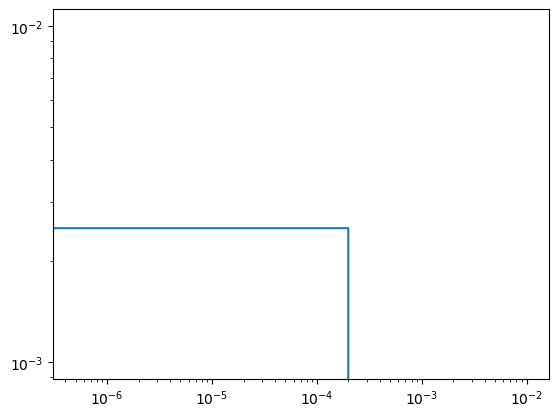

In [8]:
## Prepare filter
# filater about current with lineary cut-off
freq_smp = 5e5
filter_linram = np.zeros_like(time_clc)
filter_linram[time_clc <= rmp_time - eps] =  1/rmp_time * time_clc_int
print(filter_linram)
print(filter_linram.sum())
plt.loglog(time_clc, filter_linram)

In [9]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_bdple = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ [ tx_side/2,  tx_side/2, -tx_side/2, -tx_side/2],  # x1
             [ tx_side/2, -tx_side/2, -tx_side/2,  tx_side/2],  # x2
             [-tx_side/2,  tx_side/2,  tx_side/2, -tx_side/2],  # y1
             [ tx_side/2,  tx_side/2, -tx_side/2, -tx_side/2],  # y2
                tx_depth,  tx_depth], 
    # receiver at the center of the transmitter loop
    'freqtime' : time_clc[1:],
    'rec': [ 0,0,tx_depth,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
#    'freqtime': time_empymod,
    'signal': 0, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': n_turns* tx_area * mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 0, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [10]:
## define simulation
empymodDS =  empymodDeepSea(
    IP_model="pelton",model_base=empymod_model_bdple, 
    res_sea=res_sea, nlayers=nlayers, btm_fix=btm_fix,res_btm=res_btm,
    ramp_time=rmp_time,freq_smp=freq_smp,data_filter=filter_linram
)
## define window
empymodDS.get_window(tstrt=tstrt, tend=tend*0.99, logstep=logstep)
window_cen = empymodDS.window_cen


log step: 60


In [11]:
res = 0.2 * np.ones(nlayers)
m_r = np.log(res)
m = 0.3
m_m = m 
m_t = np.log(3e-3)*np.ones(nlayers)
m_c = 0.6*np.ones(nlayers)
mvec_obs = np.hstack([m_r, m_m,m_t,m_c])
data_clean = empymodDS.dpred(mvec_obs)
model = empymodDS.get_ip_model(mvec_obs)
print(model)

{'res': array([0.33333333, 0.2       , 1.        ]), 'rho_0': array([0.33333333, 0.2       , 1.        ]), 'm': array([0. , 0.3, 0. ]), 'tau': array([1.e-06, 3.e-03, 1.e-06]), 'c': array([0.4, 0.6, 0.4]), 'func_eta': <bound method empymodDeepSea.pelton_et_al of <__main__.empymodDeepSea object at 0x000002A187914760>>}


In [12]:
res = res_sea* np.ones(nlayers)
m_r = np.log(res)
m_m = 0
m_t = np.log(3e-4)*np.ones(nlayers)
m_c = 0.5*np.ones(nlayers)
mvec_init = np.hstack([m_r, m_m, m_t, m_c])
data_init = empymodDS.dpred(mvec_init)
print(mvec_init)
# np.save("50_data_init.npy", data_init)
# np.save('50_window_cen.npy', window_cen)

[-1.09861229  0.         -8.11172808  0.5       ]


In [13]:
#fig, ax = plt.subplots( figsize=(12, 8))
model = empymodDS.get_ip_model(mvec_init)
print(model)
#empymodDS.plot_model(mvec_init, color='C0',ax=ax)

{'res': array([0.33333333, 0.33333333, 1.        ]), 'rho_0': array([0.33333333, 0.33333333, 1.        ]), 'm': array([0., 0., 0.]), 'tau': array([1.e-06, 3.e-04, 1.e-06]), 'c': array([0.4, 0.5, 0.4]), 'func_eta': <bound method empymodDeepSea.pelton_et_al of <__main__.empymodDeepSea object at 0x000002A187914760>>}


In [36]:
relative_error=0.01
data_noise_floor = 1e-8
np.random.seed(0)
data_noisy = ( data_clean
    + np.random.randn(len(data_clean)) * relative_error * np.abs(data_clean)
#    + np.random.randn(len(data_clean)) * data_noise_floor
    )

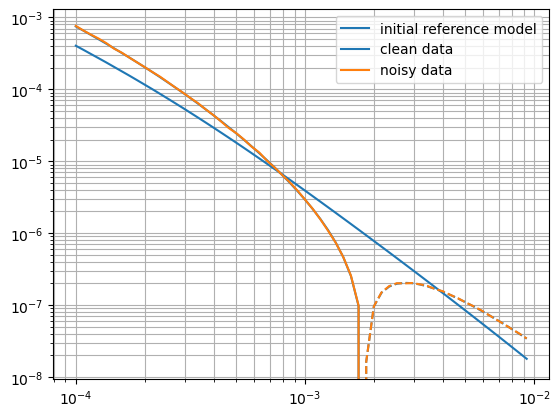

In [37]:
plt.loglog(window_cen, data_init, label="initial reference model")
plt.loglog(window_cen,  data_clean, color='C0',linestyle='-', label="clean data")
plt.loglog(window_cen, -data_clean, color='C0',linestyle='--',label="")
plt.loglog(window_cen,  data_noisy, color='C1',linestyle='-', label="noisy data")
plt.loglog(window_cen, -data_noisy, color='C1',linestyle='--',label="")

plt.grid(True, which="both")
plt.legend()

## wrap empymod in simpeg inversion framework

Simulation

In [38]:
waveform=tdem.sources.RampOffWaveform(off_time=rmp_time)

receiver= tdem.receivers.PointMagneticFluxTimeDerivative(
    locations=np.r_[0, 0, 0],times=window_cen,orientation='z')
#receiver = BaseRx(locations=np.array([[0, 0, 0]]),time_mesh=window_cen)
receiver_list = [receiver]
source = tdem.sources.CircularLoop(
    location=np.r_[0, 0, 0], radius=tx_radius, receiver_list=[receiver],
    waveform=waveform, n_turns=n_turns,
)
source_list = [source]
survey = tdem.Survey(source_list)
#simulation = empymodDS(survey=survey, poly_map=IdentityMap(nP=len(mvec_obs)))

In [39]:
simulation =  empymodDeepSea(
    survey=survey,IP_model="pelton",model_base=empymod_model_bdple, 
    res_sea=res_sea, nlayers=nlayers, btm_fix=btm_fix,res_btm=res_btm,
    ramp_time=rmp_time,freq_smp=freq_smp,data_filter=filter_linram
)
## define window
simulation.get_window(tstrt=tstrt, tend=tend*0.99, logstep=logstep)
window_cen = simulation.window_cen


log step: 60


Defining The data

In [40]:
#data_object = data.Data(survey, dobs=dobs_noisy, standard_deviation=uncertainties)

data_object = data.Data(survey, dobs=data_noisy,
     relative_error=relative_error
#     , noise_floor=data_noise_floor
)


Data Misfit

In [41]:
dmis= data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

Regularization

In [42]:
n_model = len(mvec_init)
print(n_model)
reg = regularization.Smallness(mesh=discretize.TensorMesh([n_model]))

4


Opimization

In [43]:
maxIter, maxIterCG, maxIterLS = 20,50,20
# lower = -np.inf+np.ones(n_model)
# upper =  np.inf*np.ones(n_model)
# opt = optimization.ProjectedGNCG(
#             maxIter=maxIter, lower=lower, upper=upper,
#         maxIterCG=maxIterCG, maxIterLS=maxIterLS,
# )

In [44]:
opt = optimization.InexactGaussNewton(
    maxIter=maxIter,maxIterLS=maxIterLS
    )

Inverse Problem

In [45]:
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
#inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=10)

Inverse Directives

In [50]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=0.1)
beta_schedule = directives.BetaSchedule(coolingFactor=10, coolingRate=1)
target_misfit = directives.TargetMisfit()
save = directives.SaveOutputDictEveryIteration()
directives_list = [starting_beta, beta_schedule, target_misfit, save]

# update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
# save = directives.SaveOutputDictEveryIteration()
# directives_list = [target_misfit, save]


Define and run Inversion

In [51]:
inv = inversion.BaseInversion(inv_prob, directives_list)
recovered_model = inv.run(mvec_init)

The callback on the InexactGaussNewton Optimization was replaced.

Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the empymodDeepSea problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.69e+07  3.76e+07  0.00e+00  3.76e+07    7.93e+07      0   Skip BFGS  
   1  1.69e+06  7.96e+05  1.82e-01  1.10e+06    1.28e+07      0   Skip BFGS  
   2  1.69e+05  4.57e+05  1.70e-01  4.86e+05    8.49e+05      0              
   3  1.69e+04  4.24e+05  1.71e-01  4.27e+05    2.47e+06      4              
   4  1.69e+03  4.11e+05  1.74e-01  4.12e+05    4.63e+06      4   Skip BFGS  
   5  1.69e

In [29]:
betas  = [save.outDict[i]["beta"]  for i in save.outDict.keys()]
phi_d  = [save.outDict[i]["phi_d"] for i in save.outDict.keys()]
phi_m  = [save.outDict[i]["phi_m"] for i in save.outDict.keys()]
models = [save.outDict[i]["m"]     for i in save.outDict.keys()]
fobj   = [save.outDict[i]["f"]     for i in save.outDict.keys()]
sim_models  = [save.outDict[i]["dpred"] for i in save.outDict.keys()]

In [30]:
len(save.outDict.keys())

3

In [31]:
cmp_itr = len(save.outDict.keys())

In [32]:
def plot_inversion_results_widget(ind_show):
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 4)  
    ax = [None] * 6

    ax[0] = fig.add_subplot(gs[0, 0])
    ax[1] = fig.add_subplot(gs[0, 1])
    ax[2] = fig.add_subplot(gs[1, 0])
    ax[3] = fig.add_subplot(gs[1, 1])
    ax[4] = fig.add_subplot(gs[0, 2:])
    ax[5] = fig.add_subplot(gs[1, 2:])

    axip =[ax[0], ax[1], ax[2], ax[3]]
    axip = empymodDS.plot_IP_par(model_vector=mvec_init, label="initial", color="k-",  ax=axip, linewidth=3.0)
    axip = empymodDS.plot_IP_par(model_vector=mvec_obs,  label="true",    color="b-",  ax=axip, linewidth=3.0)
    axip = empymodDS.plot_IP_par(model_vector=models[ind_show], label="predicted",color="r--",ax=axip, linewidth=3.0)
    ax[0].set_xlim([1.1,0.09])

    for i in range(2):
        tr_min, tr_max = ax[2*i].get_xlim()
        tr_z = np.linspace(tr_min, tr_max, 10)  # Adjust the number of points as needed
        ax[2*i].semilogx(tr_z, empymod_model_bdple["src"][4]* np.ones_like(tr_z), "g-",label="Src+Rec")
    for i in range(2):
        tr_min, tr_max = ax[2*i+1].get_xlim()
        tr_z = np.linspace(tr_min, tr_max, 10)  # Adjust the number of points as needed
        ax[2*i+1].plot(tr_z, empymod_model_bdple["src"][4]* np.ones_like(tr_z), "g-",label="Src+Rec")
        
    a = 1e-8
    b = 0.2
    posmax = 10**(np.log10(max(np.r_[a/10,  data_noisy,  data_init]) ) // 1 +1)
    negmax = 10**(np.log10(max(np.r_[a/10, -data_noisy, -data_init]) ) // 1 +1)
    data_plot = PsuedoLog(posmax=posmax, negmax=negmax, a=a, b=b)
    ax[4] = data_plot.pl_plot(tplot, data_init, ax=ax[4], color="k", label="initial")
    ax[4] = data_plot.pl_plot(tplot, data_noisy , ax=ax[4], color="b", label="observation")
    ax[4] = data_plot.pl_scatter(tplot, sim_models [ind_show], ax=ax[4], marker="o",s=10,color="r", label="prediction")
    ax[4] = data_plot.pl_axes(ax[4])
    ax[4].set_title("Data for each model")
    ax[4].set_ylabel("dbdt")

    ax[4].legend()
    ax[4].set_xlabel("time(msec)")


    ax[5].semilogy(fobj,label="error value",color='black')
    ax[5].semilogy(ind_show,fobj[ind_show],"o",label="index", color="red")
    ax[5].semilogy(np.arange(cmp_itr), np.ones(cmp_itr) * t.shape[0],"--k", label="phid_target")

    ax[5].set_title("Inversion Progress")
    ax[5].set_ylabel("Error value")
    ax[5].legend()
    ax[5].grid()
    ax[5].set_xlabel("iteration")

    for i in range(4):  # Iterate over rows
        ax[i].set_ylim([50, -10])
        ax[i].set_ylabel('depth')
        ax[i].legend()
        ax[i].grid()
        if i== 0 or i ==2:
            ax[i].set_xscale("log")
        else:
            ax[i].set_xscale("linear")
    plt.tight_layout()


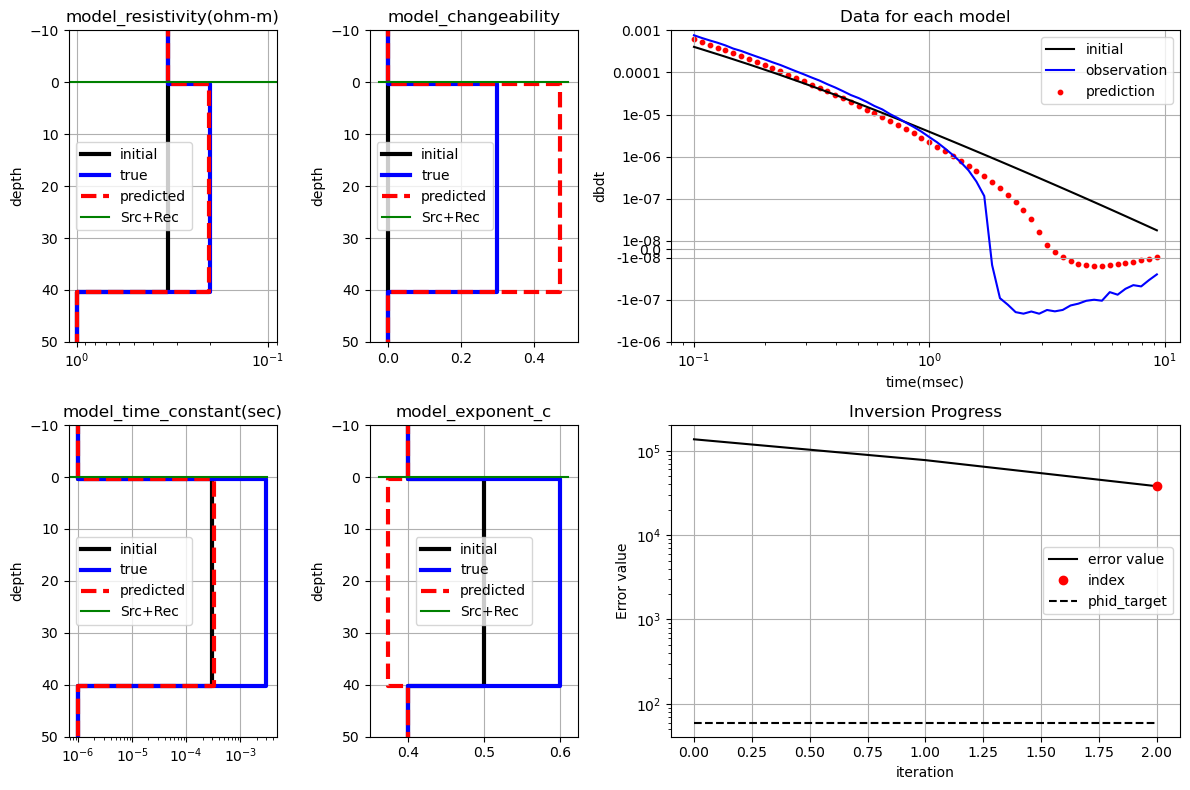

In [33]:
plot_inversion_results_widget(cmp_itr-1)


In [34]:
widgets.interact(plot_inversion_results_widget, 
    ind_show= widgets.IntSlider(min=0,max=cmp_itr-1,value=0))

interactive(children=(IntSlider(value=0, description='ind_show', max=2), Output()), _dom_classes=('widget-inte…

<function __main__.plot_inversion_results_widget(ind_show)>